In [2]:
# !pip install transformers pillow
# !pip install einops timm flash_attn

In [3]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import numpy as np
import copy
%matplotlib inline


In [4]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
'''
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
        input_ids=inputs['input_ids'],
        pixel_values=inputs['pixel_values'],
        max_new_tokens=1024,
        early_stopping=False,
        num_beams=3,
        do_sample=False,
    )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer
'''

'\ndef run_example(task_prompt, text_input=None):\n    if text_input is None:\n        prompt = task_prompt\n    else:\n        prompt = task_prompt + text_input\n\n    inputs = processor(text=prompt, images=image, return_tensors="pt")\n    generated_ids = model.generate(\n        input_ids=inputs[\'input_ids\'],\n        pixel_values=inputs[\'pixel_values\'],\n        max_new_tokens=1024,\n        early_stopping=False,\n        num_beams=3,\n        do_sample=False,\n    )\n\n    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]\n    parsed_answer = processor.post_process_generation(\n        generated_text,\n        task=task_prompt,\n        image_size=(image.width, image.height)\n    )\n\n    return parsed_answer\n'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


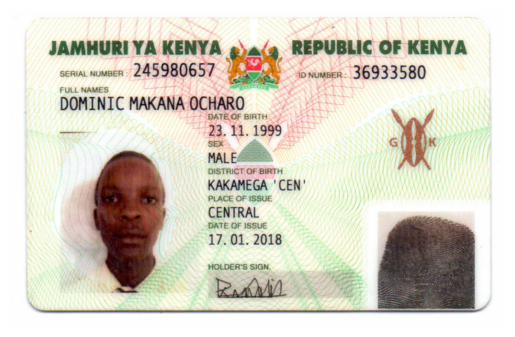

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/autolabel/front.png'

image = Image.open(image_path)
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_array = np.array(image)
    return image_array

def run_example(task_prompt, image, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    # Ensure the image is in the correct format
    image_array = preprocess_image(image)
    inputs = processor(text=prompt, images=image_array, return_tensors="pt")

    generated_ids = model.generate(
        input_ids=inputs['input_ids'],
        pixel_values=inputs['pixel_values'],
        max_new_tokens=1024,
        early_stopping=False,
        num_beams=3,
        do_sample=False,
    )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image_array.shape[1], image_array.shape[0])  # width, height
    )

    return parsed_answer

# Example usage:
task_prompt = '<CAPTION>'
result = run_example(task_prompt, image_path)
print(result)


{'<CAPTION>': "A picture of a woman's id card with a fingerprint on it."}


In [9]:
'''
task_prompt = '<CAPTION>'
run_example(task_prompt)
'''

"\ntask_prompt = '<CAPTION>'\nrun_example(task_prompt)\n"

In [10]:
task_prompt = '<DETAILED_CAPTION>'
result = run_example(task_prompt, image_path)
print(result)

{'<DETAILED_CAPTION>': "The image shows a Kenyan ID card with a picture of a woman's face, text, and a fingerprint. The card is likely used to verify the identity of the woman, as indicated by the text and fingerprint."}


In [11]:
task_prompt = '<OD>'
results = run_example(task_prompt, image_path)
print(results)


{'<OD>': {'bboxes': [[179.05499267578125, 309.7559814453125, 325.4129943847656, 522.2359619140625], [108.47100067138672, 293.1559753417969, 345.135009765625, 595.2760009765625]], 'labels': ['human face', 'person']}}


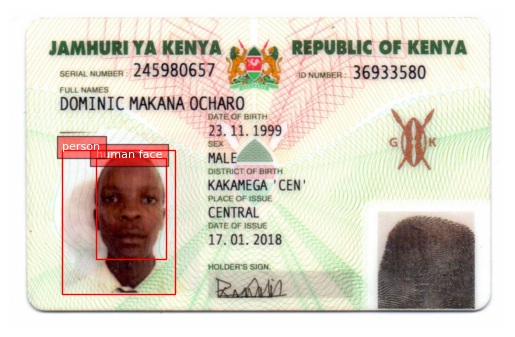

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()


plot_bbox(image, results['<OD>'])


{'<DENSE_REGION_CAPTION>': {'bboxes': [[108.47100067138672, 293.1559753417969, 345.135009765625, 595.2760009765625], [179.05499267578125, 309.09197998046875, 325.4129943847656, 522.2359619140625]], 'labels': ["Nigerian driver's license portrait", 'human face']}}


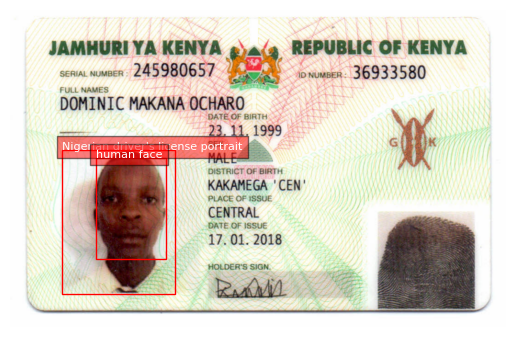

In [13]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_example(task_prompt, image_path)
print(results)

plot_bbox(image, results['<DENSE_REGION_CAPTION>'])


In [ ]:
{'<DENSE_REGION_CAPTION>': {
    'bboxes': [[26.250001907348633, 19.90799903869629, 278.25, 149.94000244140625], [154.0500030517578, 90.29999542236328, 208.0500030517578, 149.77200317382812], [126.75000762939453, 78.70800018310547, 175.95001220703125, 96.18000030517578], [61.35000228881836, 105.92399597167969, 107.55000305175781, 118.18799591064453], [31.05000114440918, 77.86799621582031, 53.55000305175781, 94.66799926757812], [77.25, 47.62799835205078, 92.55000305175781, 58.04399871826172], [111.1500015258789, 50.81999969482422, 137.5500030517578, 56.53199768066406]],
    'labels': ['BMW 4 Series Gran Coupe', 'wheel', 'headlight', 'vehicle registration plate', 'headlight', 'rearview mirror', 'steering wheel']
    }
 }


{'<DENSE_REGION_CAPTION>': {'bboxes': [[26.250001907348633,
    19.90799903869629,
    278.25,
    149.94000244140625],
   [154.0500030517578,
    90.29999542236328,
    208.0500030517578,
    149.77200317382812],
   [126.75000762939453,
    78.70800018310547,
    175.95001220703125,
    96.18000030517578],
   [61.35000228881836,
    105.92399597167969,
    107.55000305175781,
    118.18799591064453],
   [31.05000114440918,
    77.86799621582031,
    53.55000305175781,
    94.66799926757812],
   [77.25, 47.62799835205078, 92.55000305175781, 58.04399871826172],
   [111.1500015258789,
    50.81999969482422,
    137.5500030517578,
    56.53199768066406]],
  'labels': ['BMW 4 Series Gran Coupe',
   'wheel',
   'headlight',
   'vehicle registration plate',
   'headlight',
   'rearview mirror',
   'steering wheel']}}

In [ ]:
import os

# Sample data
annotations = {
    'bboxes': [
        [26.250001907348633, 19.90799903869629, 278.25, 149.94000244140625],
        [154.0500030517578, 90.29999542236328, 208.0500030517578, 149.77200317382812],
        [126.75000762939453, 78.70800018310547, 175.95001220703125, 96.18000030517578],
        [61.35000228881836, 105.92399597167969, 107.55000305175781, 118.18799591064453],
        [31.05000114440918, 77.86799621582031, 53.55000305175781, 94.66799926757812],
        [77.25, 47.62799835205078, 92.55000305175781, 58.04399871826172],
        [111.1500015258789, 50.81999969482422, 137.5500030517578, 56.53199768066406]
    ],
    'labels': ['BMW 4 Series Gran Coupe', 'wheel', 'headlight', 'vehicle registration plate', 'headlight', 'rearview mirror', 'steering wheel']
}

# Define class mapping (example)
class_mapping = {
    'BMW 4 Series Gran Coupe': 0,
    'wheel': 1,
    'headlight': 2,
    'vehicle registration plate': 3,
    'rearview mirror': 4,
    'steering wheel': 5
}

# Image dimensions (example)
img_width = 640
img_height = 480

# Convert bounding box to YOLO format
def convert_to_yolo_format(box, img_width, img_height):
    x_min, y_min, x_max, y_max = box
    x_center = (x_min + x_max) / 2 / img_width
    y_center = (y_min + y_max) / 2 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height
    return x_center, y_center, width, height

# Format labels
yolo_labels = []
for box, label in zip(annotations['bboxes'], annotations['labels']):
    class_id = class_mapping[label]
    x_center, y_center, width, height = convert_to_yolo_format(box, img_width, img_height)
    yolo_labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

# Save to a TXT file
output_label_path = '/content/drive/MyDrive/models/labels.txt'
with open(output_label_path, 'w') as f:
    f.write("\n".join(yolo_labels))


{'<REGION_PROPOSAL>': {'bboxes': [[26.250001907348633, 19.90799903869629, 278.25, 149.77200317382812], [153.75, 90.46800231933594, 208.0500030517578, 149.77200317382812], [241.95001220703125, 83.91600036621094, 276.45001220703125, 132.8040008544922], [126.75000762939453, 78.8759994506836, 175.95001220703125, 96.18000030517578], [61.35000228881836, 105.92399597167969, 107.55000305175781, 118.18799591064453], [63.750003814697266, 118.86000061035156, 113.25000762939453, 130.11599731445312], [181.35000610351562, 35.02799987792969, 202.95001220703125, 56.19599914550781], [31.350000381469727, 77.86799621582031, 53.55000305175781, 94.66799926757812], [135.75, 115.66799926757812, 163.95001220703125, 128.09999084472656], [211.95001220703125, 133.97999572753906, 211.95001220703125, 47.29199981689453], [235.0500030517578, 59.555999755859375, 76.95000457763672, 47.62799835205078], [92.85000610351562, 62.74799728393555, 30.150001525878906, 113.6520004272461], [48.45000076293945, 126.08399963378906,

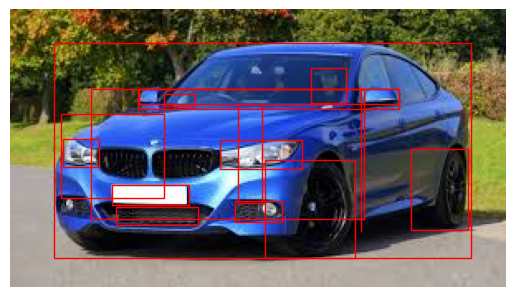

In [ ]:
task_prompt = '<REGION_PROPOSAL>'
results = run_example(task_prompt, image_path)
print(results)

plot_bbox(image, results['<REGION_PROPOSAL>'])
